# Benchmarking Neighbor Finding against scipy
The neighbor finding algorithms in freud are highly efficient and rely on parallelized C++ code. Below, we show a benchmark of freud's `AABBQuery` and `LinkCell` algorithms against the `scipy.spatial.cKDTree`. This benchmark was run on an Intel(R) Core(TM) i3-8100B CPU @ 3.60GHz.

In [1]:
import freud
import scipy
import numpy as np
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm

In [2]:
def make_scaled_system(N, Nneigh=12):
    L = (4 / 3 * np.pi * N / Nneigh)**(1/3)
    box = freud.box.Box.cube(L)
    seed = 0
    np.random.seed(seed)
    points = np.random.uniform(-L/2, L/2, (N, 3))
    return box, points

box, points = make_scaled_system(1000)

## Timing Functions

In [3]:
def time_statement(stmt, repeat=5, number=100, **kwargs):
    timer = timeit.Timer(stmt=stmt, globals=kwargs)
    times = timer.repeat(repeat, number)
    return np.mean(times), np.std(times)

In [4]:
def time_freud_lc(box, points):
    return time_statement("lc = freud.locality.LinkCell(box, rcut);"
                          "lc.compute(box, points, exclude_ii=False)",
                          freud=freud, box=box, points=points, rcut=1.0)

In [5]:
def time_freud_abq(box, points):
    return time_statement("aq = freud.locality.AABBQuery(box, points);"
                          "aq.queryBall(points, rcut, exclude_ii=False).toNList()",
                          freud=freud, box=box, points=points, rcut=1.0)

In [6]:
def time_scipy_ckdtree(box, points):
    shifted_points = points + np.asarray(box.L)/2
    # SciPy only supports cubic boxes
    assert box.Lx == box.Ly == box.Lz
    assert box.xy == box.xz == box.yz == 0
    return time_statement("kdtree = scipy.spatial.cKDTree(points, boxsize=L);"
                          "kdtree.query_ball_tree(kdtree, r=rcut)",
                          scipy=scipy, points=shifted_points, L=box.Lx, rcut=1.0)

In [7]:
# Test timing functions
lc_t = time_freud_lc(box, points)
print(lc_t)
abq_t = time_freud_abq(box, points)
print(abq_t)
kd_t = time_scipy_ckdtree(box, points)
print(kd_t)

(0.118918436, 0.003592257320728501)
(0.11153316980000012, 0.002647679687358477)
(0.48859084159999994, 0.0031191134541460257)


## Perform Measurements

In [8]:
def measure_runtime_scaling_N(Ns, rcut=1.0):
    result_times = []
    for N in tqdm(Ns):
        box, points = make_scaled_system(N)
        result_times.append((
            time_scipy_ckdtree(box, points),
            time_freud_abq(box, points),
            time_freud_lc(box, points)))
    return np.asarray(result_times)

In [9]:
def plot_result_times(result_times, Ns):
    plt.figure(figsize=(6, 4), dpi=200)
    plt.errorbar(Ns, result_times[:, 0, 0], result_times[:, 0, 1], label="scipy v{} cKDTree".format(scipy.__version__))
    plt.errorbar(Ns, result_times[:, 1, 0], result_times[:, 1, 1], label="freud v{} AABBQuery".format(freud.__version__))
    plt.errorbar(Ns, result_times[:, 2, 0], result_times[:, 2, 1], label="freud v{} LinkCell".format(freud.__version__))
    plt.title(r'Neighbor finding for 12 average neighbors')
    plt.xlabel(r'Number of points $N$')
    plt.ylabel(r'Runtime for 100 iterations (s)')
    plt.legend()
    plt.show()

In [10]:
# Use geometrically-spaced values of N, rounded to one significant figure
Ns = list(sorted(set(map(
    lambda x: int(round(x, -int(np.floor(np.log10(np.abs(x)))))),
    np.exp(np.linspace(np.log(50), np.log(5000), 10))))))

100%|██████████| 10/10 [00:41<00:00,  8.46s/it]


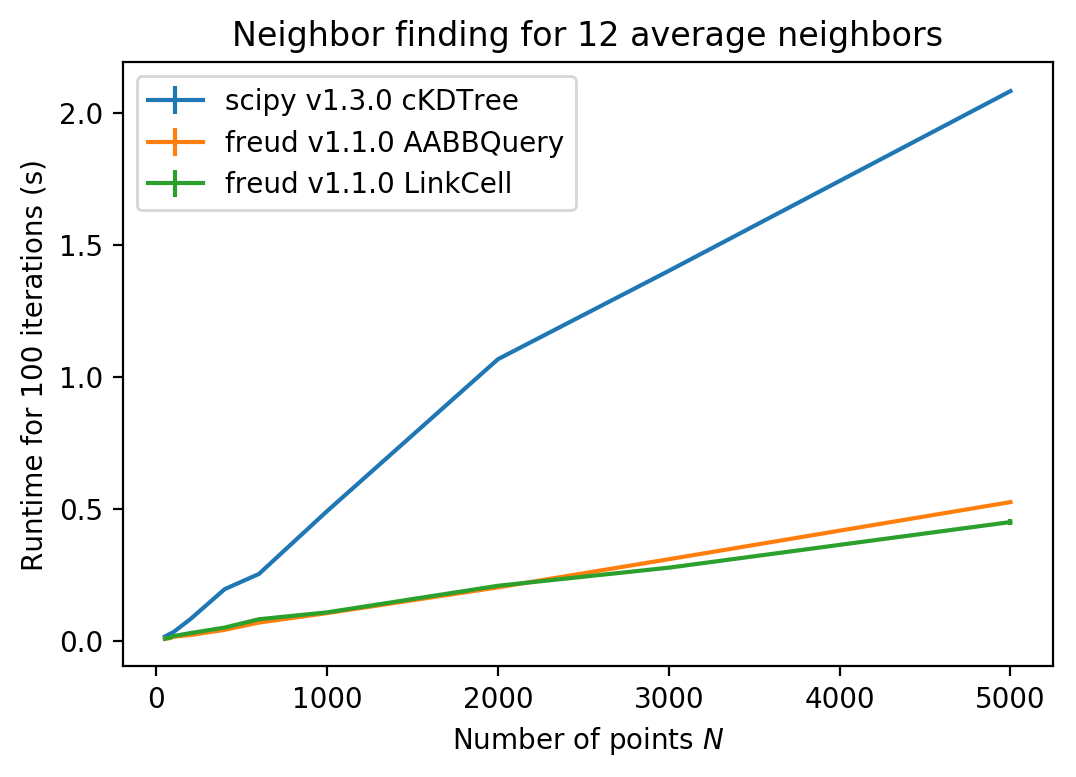

In [11]:
result_times = measure_runtime_scaling_N(Ns)
plot_result_times(result_times, Ns)